# Capstone Project: Fast-Charging of Electric Vehicles

### By: Rajesh Radhakrishnan (March 2025)

Problem Statement:
What is the relationship between Energy used for charging (Wh) and the characteristics of the Electric Vehicle's Battery?

Dataset: https://github.com/DESL-EPFL/Level-3-EV-charging-dataset/blob/main/Session_data.xlsx

The dataset consists of Level-3 charging sessions of Electric Vehicles over a period in 2022-2023. The charging station has a total of 6 plugs but data is collected from the two CCS plugs. The maximum power of the charging station is 172.5 kW and two EVs can be supplied at the same time.

Techniques expected to use in the analyis: Regression Analysis, Classification algorithms like Logistic Regression, KNN, DecisionTrees and Support Vector Machines

Expected Results: The energy consumed for charging is proportional to the change in the state of charge (SOC) of the EV battery and the peak rate of charging.

Why is question important: The cost of electric vehicle charging is based on the energy consumed for the charging session. Based on the regression model formulated in this project, the amount of energy consumed can be predicted based on the change in the  state of charge and the peak rate of charging thus providing an estimate to the user of the charging cost for the session.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [2]:
# display all columns of dataframe
pd.set_option('display.max_columns', None)

In [3]:
# read the dataset from the excel file = "Session_data.xlsx"
ev_df = pd.read_excel('data/Session_data.xlsx')

In [4]:
ev_df.head()

,Session,CCS,Arrival,Departure,Stay (min),Energy (Wh),Pmax (W),Preq_max (W),"Controlled session (0=False, 1=True)",TotalCapacity,BulkCapacity,SOC arrival,SOC departure,Energy capacity (Wh)
0,278,CCS1,2022-08-11 23:33:00,2022-08-11 23:37:00,5,9632.0,168393,192417,1,79140,63312,25.999495,35.999495,91504.000000
1,897,CCS1,2023-04-22 09:46:00,2023-04-22 09:50:00,5,3993.0,87201,192417,1,75200,60160,45.000000,49.000000,94833.750000
2,958,CCS1,2023-05-18 13:24:00,2023-05-18 13:28:00,5,4567.0,79593,252297,1,10000,8000,21.000000,27.000000,72310.833333
3,1046,CCS1,2023-06-18 16:14:00,2023-06-18 16:18:00,5,5591.0,120198,232965,1,10000,8000,46.990000,55.000000,66310.237203
4,1095,CCS1,2023-06-28 14:39:00,2023-06-28 14:43:00,5,6400.0,128517,353265,1,10000,8000,45.000000,54.000000,67555.555556


In [5]:
ev_df.tail()

,Session,CCS,Arrival,Departure,Stay (min),Energy (Wh),Pmax (W),Preq_max (W),"Controlled session (0=False, 1=True)",TotalCapacity,BulkCapacity,SOC arrival,SOC departure,Energy capacity (Wh)
1873,668,CCS1,2023-03-03 16:45:00,2023-03-03 18:58:00,134,60079.0,101439,275928,1,10000,8000,20.0,97.00,74123.441558
1874,778,CCS1,2023-03-29 10:33:00,2023-03-29 12:46:00,134,30498.0,64902,123921,1,10000,8000,51.0,98.00,61644.893617
1875,61,CCS1,2022-04-28 14:32:00,2022-04-28 16:48:00,137,268863.0,150498,223296,1,10000,8000,25.0,93.99,370227.351790
1876,743,CCS1,2023-03-21 13:45:00,2023-03-21 16:05:00,141,46939.0,51609,56808,1,10000,8000,6.0,100.00,47438.351064
1877,1750,CCS2,2023-05-14 13:38:00,2023-05-14 16:01:00,144,50409.0,51552,55773,1,10000,8000,3.0,100.00,49369.639175


### Description of the fields

<u>Identifier</u>:    <u>Description</u>  
Session ID: number attributed to the charging session  
CCS: Plug ID (CCS1 or CCS2)  
Arrival: EV arrival time  
Departure: EV departure time  
Stay: EV stay duration (min)  
Energy: Charged energy (Wh)  
Pmax: Maximum AC charging power of the session (W)  
Preq_max: Maximum Requested AC charging power of the session (W)  
Controlled session:	Boolean identifying whether Pset < Preq anytime during the charging session (0=False, 1=True)  
TotalCapacity: Total energy capacity of the EV’s battery (a-dimensional)  
BulkCapacity: Usable energy capacity of the EV’s battery (a-dimensional)  
SOC arrival: State-of-charge of the EV’s battery at arrival (%)  
SOC departure: State-of-charge of the EV’s battery at departure (%)  
Energy capacity: Approximated capacity of the EV’s battery (Wh)  

In [6]:
ev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Session                               1878 non-null   int64         
 1   CCS                                   1878 non-null   object        
 2   Arrival                               1878 non-null   datetime64[ns]
 3   Departure                             1878 non-null   datetime64[ns]
 4   Stay (min)                            1878 non-null   int64         
 5   Energy (Wh)                           1878 non-null   float64       
 6   Pmax (W)                              1878 non-null   int64         
 7   Preq_max (W)                          1878 non-null   int64         
 8   Controlled session (0=False, 1=True)  1878 non-null   int64         
 9   TotalCapacity                         1878 non-null   int64         
 10  

In [7]:
ev_df.describe()

,Session,Arrival,Departure,Stay (min),Energy (Wh),Pmax (W),Preq_max (W),"Controlled session (0=False, 1=True)",TotalCapacity,BulkCapacity,SOC arrival,SOC departure,Energy capacity (Wh)
count,1878.000000,1878,1878,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000
mean,939.500000,2022-12-15 03:35:37.380191488,2022-12-15 04:07:32.332268544,32.915868,32184.204247,102494.722045,209408.234824,0.753994,16161.735889,12891.472311,33.674322,79.140417,69682.303637
min,1.000000,2022-04-12 19:27:00,2022-04-12 19:38:00,5.000000,1165.000000,13986.000000,24000.000000,0.000000,10000.000000,1000.000000,0.000000,12.000000,9748.055556
25%,470.250000,2022-08-11 17:24:45,2022-08-11 17:54:00,20.000000,17979.750000,65060.250000,123081.000000,1.000000,10000.000000,8000.000000,19.000000,70.000000,57187.462607
50%,939.500000,2022-11-20 17:19:30,2022-11-20 17:55:00,30.000000,29367.000000,97654.500000,191382.000000,1.000000,10000.000000,8000.000000,31.000000,82.990000,72839.346877
75%,1408.750000,2023-04-09 16:39:30,2023-04-09 17:17:15,42.000000,43285.250000,145188.000000,352230.000000,1.000000,10000.000000,8000.000000,46.000000,93.000000,80505.223164
max,1878.000000,2023-07-04 23:03:00,2023-07-04 23:48:00,144.000000,268863.000000,174846.000000,367872.000000,1.000000,80640.000000,64512.000000,98.000000,100.000000,382028.378378
std,542.276221,NaN,NaN,17.580331,19407.367487,41905.368685,100409.651859,0.430797,17267.102475,13713.326583,19.147568,18.404431,30210.323248


In [8]:
ev_df.isna().sum()

Session                                 0
CCS                                     0
Arrival                                 0
Departure                               0
Stay (min)                              0
Energy (Wh)                             0
Pmax (W)                                0
Preq_max (W)                            0
Controlled session (0=False, 1=True)    0
TotalCapacity                           0
BulkCapacity                            0
SOC arrival                             0
SOC departure                           0
Energy capacity (Wh)                    0
dtype: int64

## Exploratory Data Analysis

In [9]:
# Transformation of variables
# rename controlled session column
ev_df = ev_df.rename(columns={'Controlled session (0=False, 1=True)':'Controlled session'})
# add columns for change in state of charge
ev_df['SOC change'] = ev_df['SOC departure'] - ev_df['SOC arrival']
# booleans = arrival state of charge greater than 50% and departure state of charge greater than 50%
ev_df['SOC arrival gt 50'] = np.where(ev_df['SOC arrival'] > 50, 1, 0)
ev_df['SOC departure gt 50'] = np.where(ev_df['SOC departure'] > 50, 1, 0)
# change in state of charge greater than 50%
ev_df['SOC change gt 50'] = np.where(ev_df['SOC change'] > 50, 1, 0)
# hour of arrival and departure
ev_df['Hour of arrival'] = pd.to_datetime(ev_df['Arrival']).dt.hour
ev_df['Hour of departure'] = pd.to_datetime(ev_df['Departure']).dt.hour
# energy charged percent of energy cap
ev_df['Percent Energy charged to cap'] = round(100.0 * (ev_df['Energy (Wh)'] / ev_df['Energy capacity (Wh)']),2)
# percent of max power to requested power
ev_df['Percent max power to req power'] = round(100.0*(ev_df['Pmax (W)'] / ev_df['Preq_max (W)']),2)

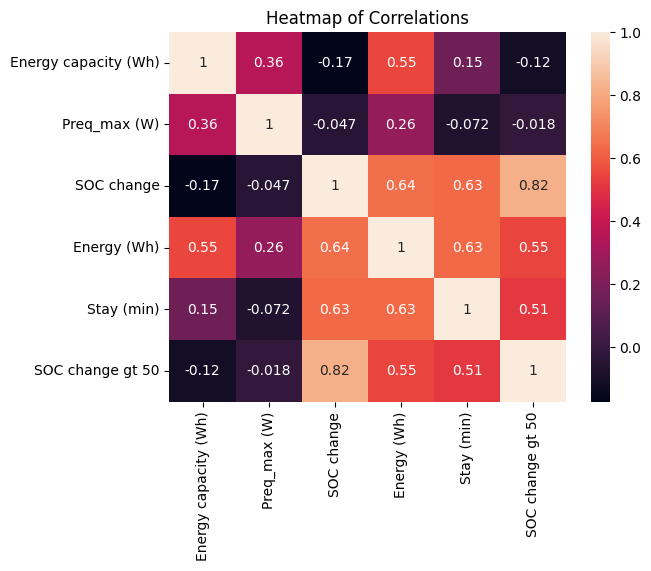

In [10]:
# correlations
sns.heatmap(ev_df[['Energy capacity (Wh)','Preq_max (W)','SOC change','Energy (Wh)','Stay (min)','SOC change gt 50']].corr(), annot=True)
plt.title('Heatmap of Correlations')
plt.show()

The Energy Charged is has a correlation of 0.64 with the change in SOC

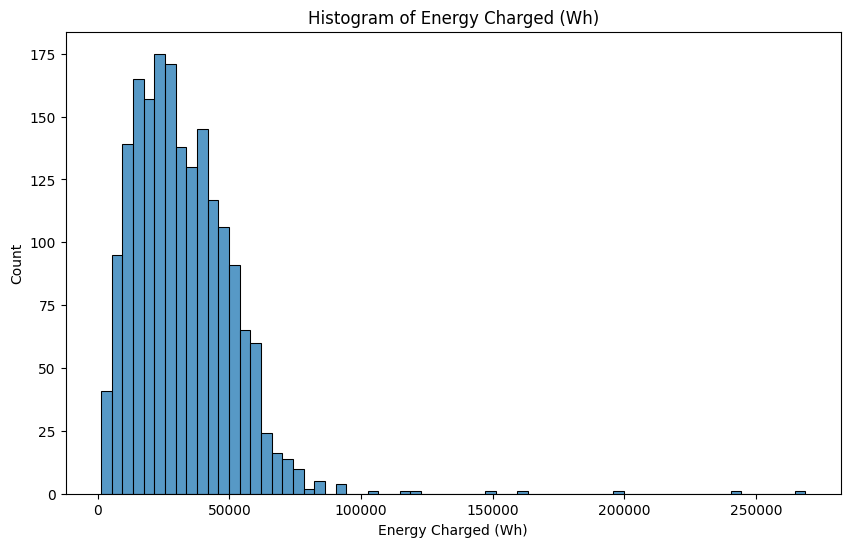

In [11]:
# Histogram of Energy Wh
plt.figure(figsize=(10,6))
sns.histplot(ev_df['Energy (Wh)'])
plt.title('Histogram of Energy Charged (Wh)')
plt.xlabel('Energy Charged (Wh)')
plt.ylabel('Count')
plt.show()

There are a few outliers (exceeding 100,000 Wh) but the peak of the distribution is seen to be around 25,000 Wh

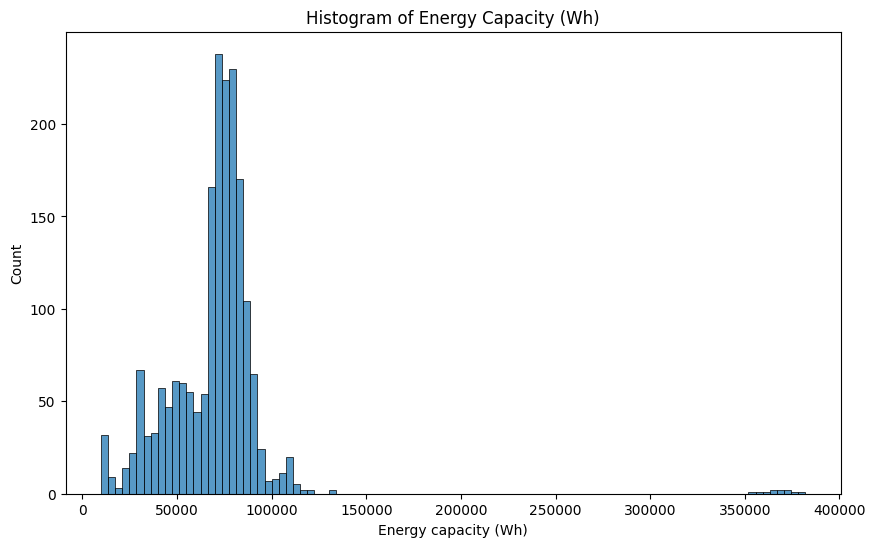

In [12]:
# Histogram of Energy capacity (Wh)
plt.figure(figsize=(10,6))
sns.histplot(ev_df['Energy capacity (Wh)'])
plt.title('Histogram of Energy Capacity (Wh)')
plt.xlabel('Energy capacity (Wh)')
plt.ylabel('Count')
plt.show()

There are a few outliers at 350k Wh but the peak of the distribution is at 70k-75k Wh

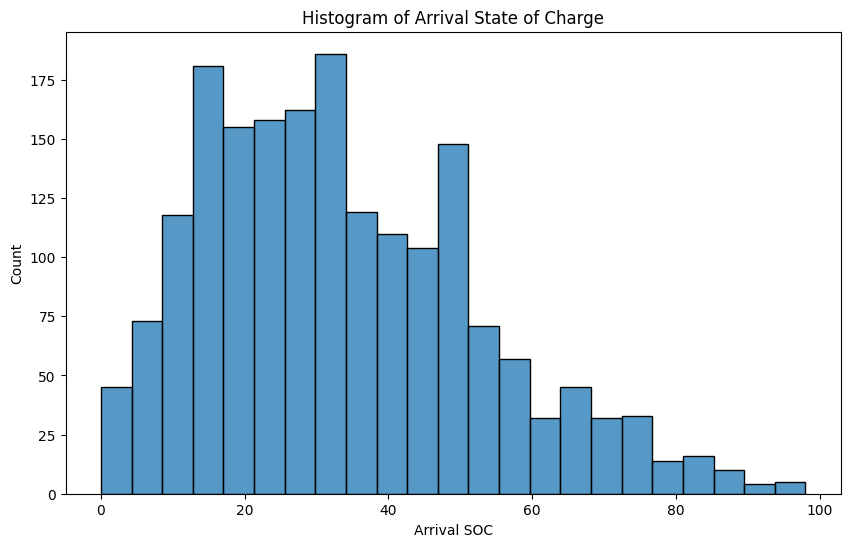

In [13]:
# Histogram of SOC Arrival
plt.figure(figsize=(10,6))
sns.histplot(ev_df['SOC arrival'])
plt.title('Histogram of Arrival State of Charge')
plt.xlabel('Arrival SOC')
plt.ylabel('Count')
plt.show()

Most EVs arrive with SOC less than 50 percent

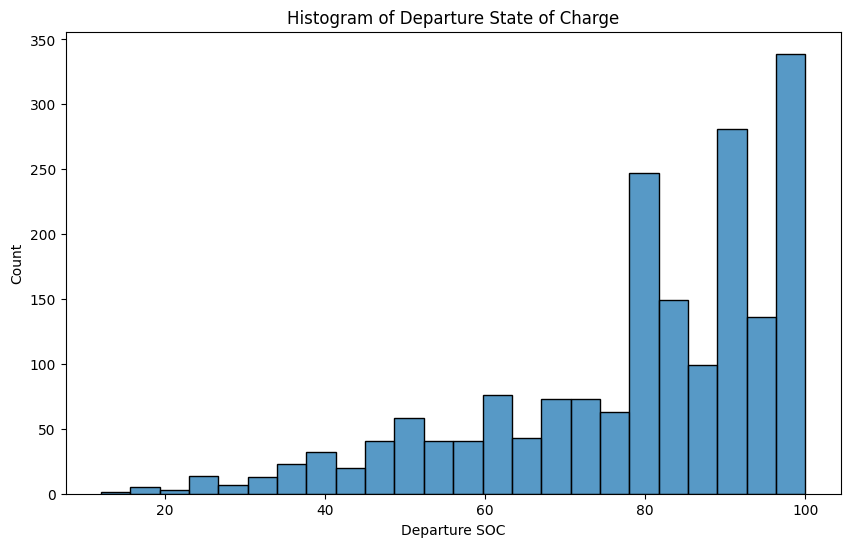

In [14]:
# Histogram of SOC Departure
plt.figure(figsize=(10,6))
sns.histplot(ev_df['SOC departure'])
plt.title('Histogram of Departure State of Charge')
plt.xlabel('Departure SOC')
plt.ylabel('Count')
plt.show()

Most EVs depart with a State of Charge greater than or equal to 80 %

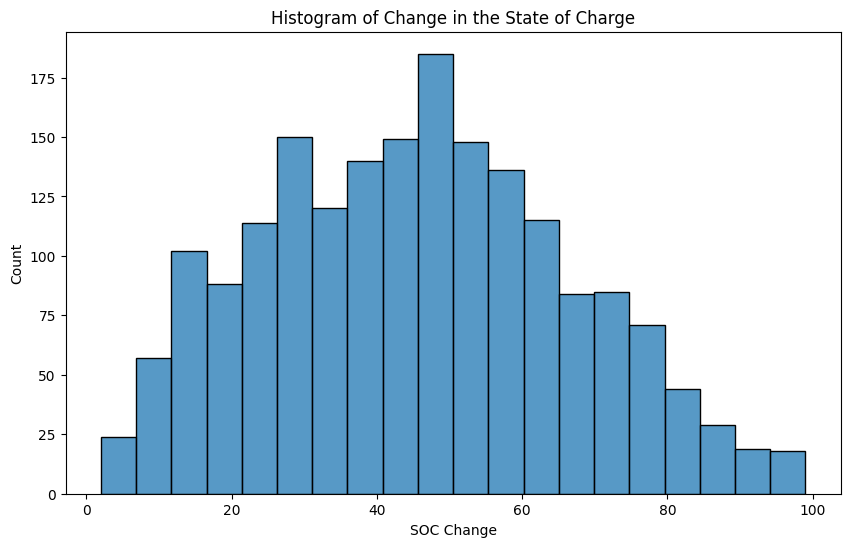

In [15]:
# Histogram of SOC Change
plt.figure(figsize=(10,6))
sns.histplot(data=ev_df, x='SOC change')
plt.title('Histogram of Change in the State of Charge')
plt.xlabel('SOC Change')
plt.ylabel('Count')
plt.show()

The distribution of the change in SOC is almost symmetrical around 50 percent

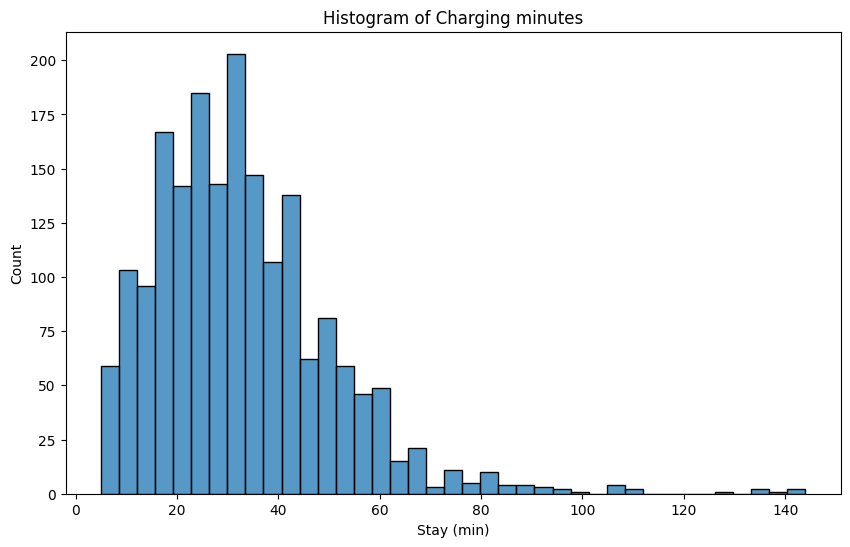

In [16]:
# Histogram of Stay (min)
plt.figure(figsize=(10,6))
sns.histplot(data=ev_df, x='Stay (min)')
plt.title('Histogram of Charging minutes')
plt.xlabel('Stay (min)')
plt.ylabel('Count')
plt.show()

Some cars take more than 100 minutes for charging but the largest number take around 30 minutes.

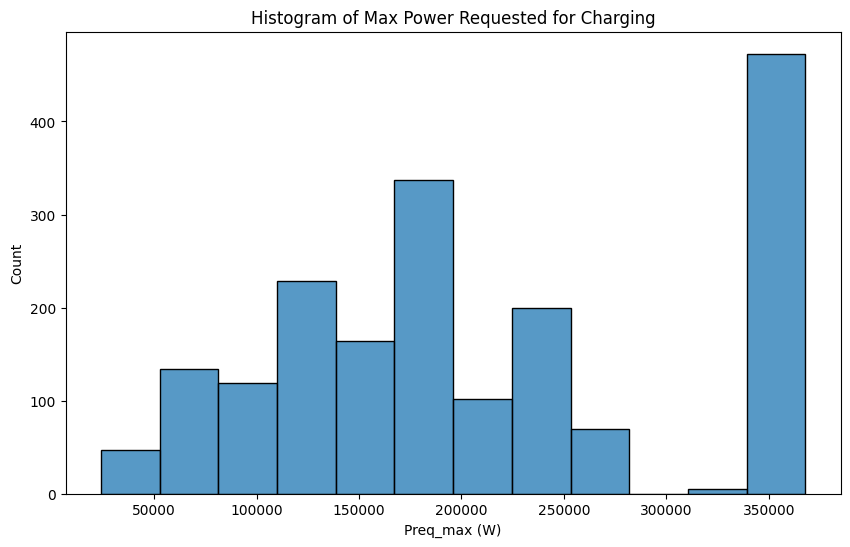

In [17]:
# Histogram of max Power Requested
plt.figure(figsize=(10,6))
sns.histplot(data=ev_df, x='Preq_max (W)')
plt.title('Histogram of Max Power Requested for Charging')
plt.xlabel('Preq_max (W)')
plt.ylabel('Count')
plt.show()

Max power requested has max number of charges at 350kW

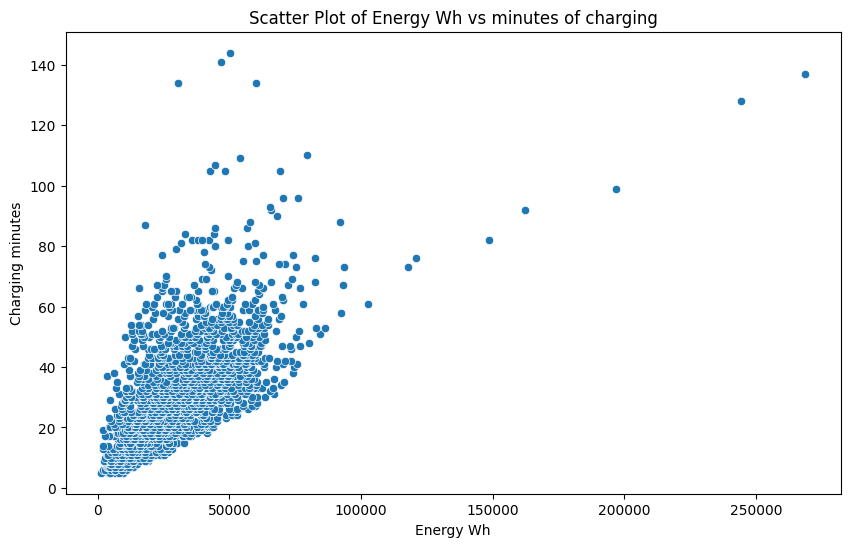

In [18]:
# Scatter plot of Energy Wh vs minutes for charging
plt.figure(figsize=(10,6))
sns.scatterplot(data=ev_df, x='Energy (Wh)', y='Stay (min)')
plt.title('Scatter Plot of Energy Wh vs minutes of charging')
plt.xlabel('Energy Wh')
plt.ylabel('Charging minutes')
plt.show()

The scatter plot indicates a positive correlation between Energy Wh and Charging minutes.

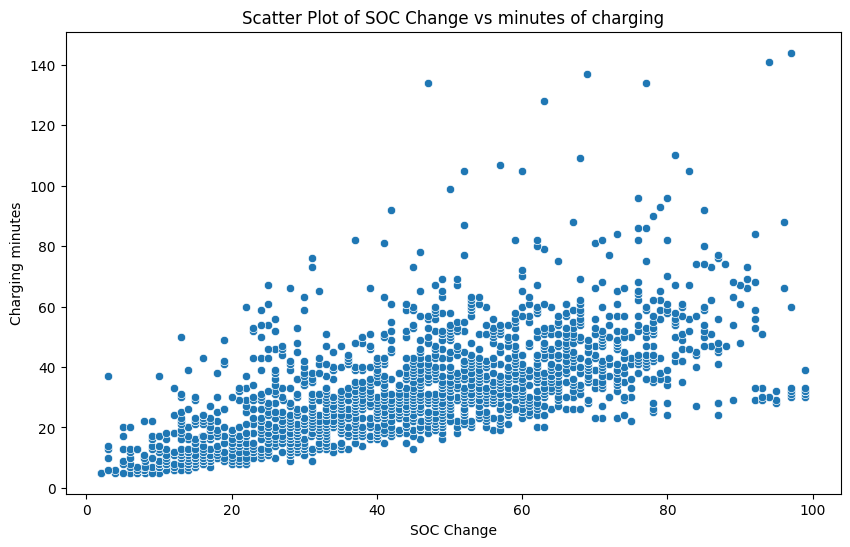

In [19]:
# Scatter plot of SOC Change vs Stay minutes
plt.figure(figsize=(10,6))
sns.scatterplot(data=ev_df, x='SOC change', y='Stay (min)')
plt.title('Scatter Plot of SOC Change vs minutes of charging')
plt.xlabel('SOC Change')
plt.ylabel('Charging minutes')
plt.show()

This scatter plot also indicates a positive relationship between change in SOC and charging minutes.

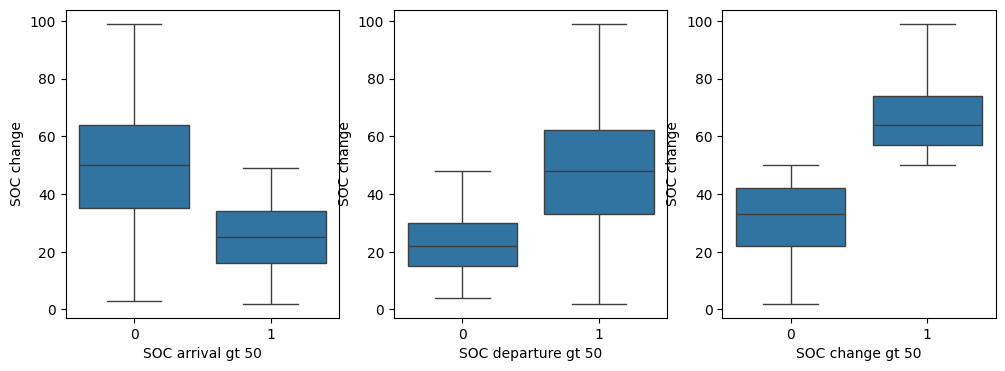

In [20]:
# Box Plot - SOC change versus boolean variables
fig, axes = plt.subplots(1, 3, figsize=(12,4))
sns.boxplot(data=ev_df,x='SOC arrival gt 50',y='SOC change',ax=axes[0])
sns.boxplot(data=ev_df,x='SOC departure gt 50',y='SOC change',ax=axes[1])
sns.boxplot(data=ev_df,x='SOC change gt 50',y='SOC change',ax=axes[2])
plt.show()

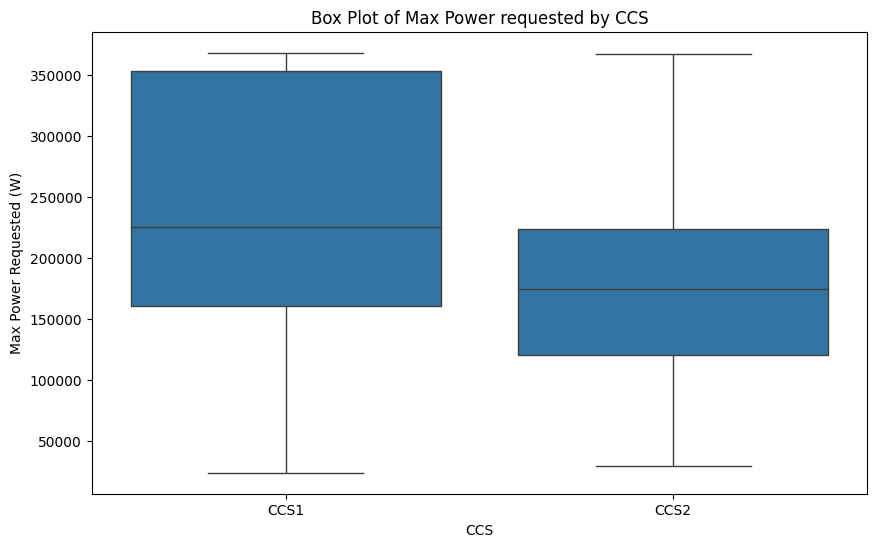

In [21]:
# Box Plot of CCS vs Preq_max (W)
plt.figure(figsize=(10,6))
sns.boxplot(data=ev_df,x='CCS',y='Preq_max (W)')
plt.title('Box Plot of Max Power requested by CCS')
plt.xlabel('CCS')
plt.ylabel('Max Power Requested (W)')
plt.show()

CCS1 has a higher median max power requested compared to CCS2

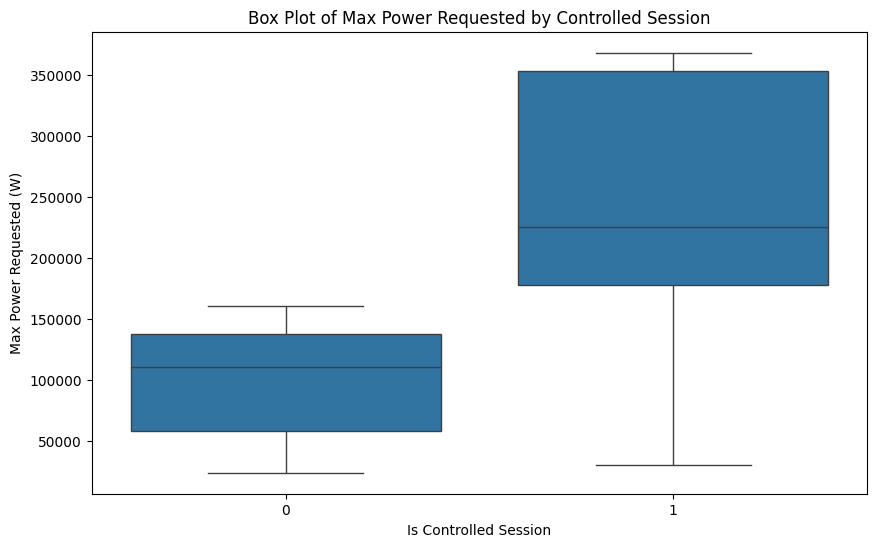

In [22]:
# Box Plot of Max Power requested vs Controlled Session boolean
plt.figure(figsize=(10,6))
sns.boxplot(data=ev_df,x='Controlled session',y='Preq_max (W)')
plt.title('Box Plot of Max Power Requested by Controlled Session')
plt.xlabel('Is Controlled Session')
plt.ylabel('Max Power Requested (W)')
plt.show()

Controlled Sessions have a higher max power requested than not controlled ones.

## Regression Analysis

In [23]:
# numerical and categorical columns (for X matrix)
numerical_columns = ['Energy capacity (Wh)','Preq_max (W)','SOC change']
categorical_columns = ['CCS']
X = pd.concat([ev_df[numerical_columns],ev_df[categorical_columns]],axis=1)
y = ev_df['Energy (Wh)']

In [24]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# preprocessor and pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

lin_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lin_reg', LinearRegression(fit_intercept=False))
])

In [26]:
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Energy capacity (Wh)',
                                                   'Preq_max (W)',
                                                   'SOC change']),
                                                 ('cat', OneHotEncoder(),
                                                  ['CCS'])])),
                ('lin_reg', LinearRegression(fit_intercept=False))])

In [27]:
y_pred_train = lin_reg_pipe.predict(X_train)
y_pred_test = lin_reg_pipe.predict(X_test)
r_squared = round(lin_reg_pipe.score(X_test, y_test),4)
rmse_train = round(np.sqrt(mean_squared_error(y_pred_train, y_train)),4)
rmse_test = round(np.sqrt(mean_squared_error(y_pred_test, y_test)),4)

print('rmse_train:',rmse_train,'\nrmse_test:',rmse_test,'\n')
print('R-squared:',r_squared)

# adjusted R-squared
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r_squared = round(1 - ((1 - r_squared) * (n - 1) / (n - p - 1)),4)
print('Adjusted R-squared:',adjusted_r_squared)

rmse_train: 7037.9378 
rmse_test: 7630.7954 

R-squared: 0.8444
Adjusted R-squared: 0.8427


In [28]:
# Coefficients
encoded_columns = lin_reg_pipe.named_steps['preprocessor']['cat'].get_feature_names_out()
total_columns = numerical_columns + list(encoded_columns) 
pd.DataFrame({'Name':total_columns,'Coeff':lin_reg_pipe.named_steps['lin_reg'].coef_})

,Name,Coeff
0,Energy capacity (Wh),12892.530067
1,Preq_max (W),983.666117
2,SOC change,14658.868020
3,CCS_CCS1,32128.296117
4,CCS_CCS2,31800.922682


In [29]:
# intercept should be zero
lin_reg_pipe.named_steps['lin_reg'].intercept_

0.0

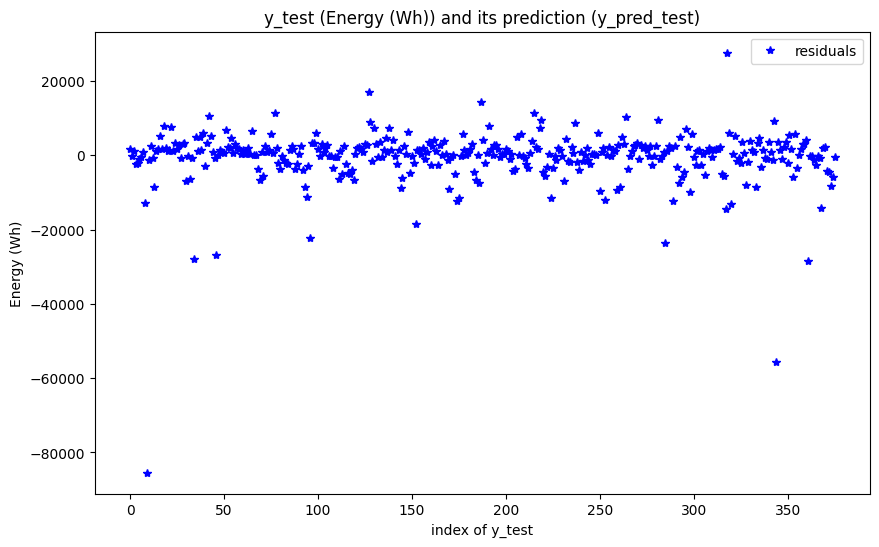

In [30]:
# residuals plot
y_pred_test = lin_reg_pipe.predict(X_test)
residuals = y_test - y_pred_test

plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), residuals, label='residuals', linestyle='', marker='*', color='b')
plt.title('y_test (Energy (Wh)) and its prediction (y_pred_test)')
plt.xlabel('index of y_test')
plt.ylabel('Energy (Wh)')
plt.legend()
plt.show()

The residuals are randomly distributed without any pattern, as desired.

In [31]:
# p-values (using StatsModel)
X_train_transformed = preprocessor.fit_transform(X_train)
model = sm.OLS(y_train,X_train_transformed)
fitted_model = model.fit()
p_values = fitted_model.summary2().tables[1]['P>|t|']
p_values

x1    0.000000
x2    0.000002
x3    0.000000
x4    0.000000
x5    0.000000
Name: P>|t|, dtype: float64

The p-values indicate that the coefficients of the variables in the model are all significant (meaning different from zero).

In [32]:
# Regression model for Predicting Change in State of Charge given the other inputs

In [33]:
numerical_columns = ['Energy capacity (Wh)','Preq_max (W)','Energy (Wh)']
categorical_columns = ['CCS']
X = pd.concat([ev_df[numerical_columns],ev_df[categorical_columns]],axis=1)
y = ev_df['SOC change']

In [34]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# preprocessor and pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

lin_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lin_reg', LinearRegression(fit_intercept=False))
])

In [36]:
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Energy capacity (Wh)',
                                                   'Preq_max (W)',
                                                   'Energy (Wh)']),
                                                 ('cat', OneHotEncoder(),
                                                  ['CCS'])])),
                ('lin_reg', LinearRegression(fit_intercept=False))])

In [37]:
y_pred_train = lin_reg_pipe.predict(X_train)
y_pred_test = lin_reg_pipe.predict(X_test)
r_squared = round(lin_reg_pipe.score(X_test, y_test),4)
rmse_train = round(np.sqrt(mean_squared_error(y_pred_train, y_train)),2)
rmse_test = round(np.sqrt(mean_squared_error(y_pred_test, y_test)),2)

print('rmse_train:',rmse_train,'\nrmse_test:',rmse_test)
print('R-squared:',r_squared)

rmse_train: 8.97 
rmse_test: 9.9
R-squared: 0.7969


In [38]:
# Coefficients
encoded_columns = lin_reg_pipe.named_steps['preprocessor']['cat'].get_feature_names_out()
total_columns = numerical_columns + list(encoded_columns) 
pd.DataFrame({'Name':total_columns,'Coeff':lin_reg_pipe.named_steps['lin_reg'].coef_})

,Name,Coeff
0,Energy capacity (Wh),-15.458174
1,Preq_max (W),-1.047652
2,Energy (Wh),22.240597
3,CCS_CCS1,44.719402
4,CCS_CCS2,45.328287


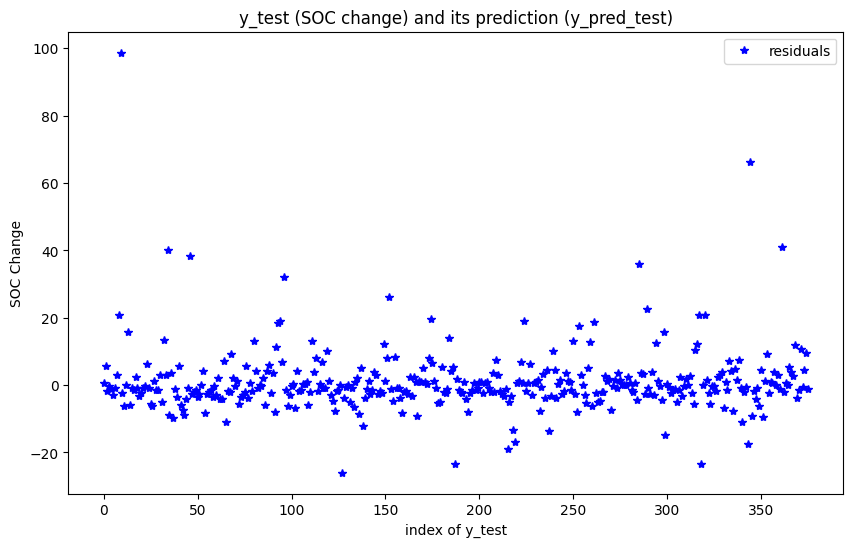

In [39]:
# residuals plot
y_pred_test = lin_reg_pipe.predict(X_test)
residuals = y_test - y_pred_test

plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), residuals, label='residuals', linestyle='', marker='*', color='b')
plt.title('y_test (SOC change) and its prediction (y_pred_test)')
plt.xlabel('index of y_test')
plt.ylabel('SOC Change')
plt.legend()
plt.show()

In [40]:
# p-values (using StatsModel)
X_train_transformed = preprocessor.fit_transform(X_train)
model = sm.OLS(y_train,X_train_transformed)
fitted_model = model.fit()
p_values = fitted_model.summary2().tables[1]['P>|t|']
p_values

x1    0.000000
x2    0.000059
x3    0.000000
x4    0.000000
x5    0.000000
Name: P>|t|, dtype: float64

The p-values indicate that the coefficients of the variables in the model are all significant (meaning different from zero).

## Classification Algorithms

In [41]:
# Classification of Change in SOC greater than 50
numerical_columns = ['Energy capacity (Wh)','Stay (min)','Preq_max (W)','Controlled session']
categorical_columns = ['CCS']
X_class = pd.concat([ev_df[numerical_columns],ev_df['CCS']],axis=1)
y_class = ev_df['SOC change gt 50']

In [42]:
# Function to display classification report, confustion matrix and accuracy score
def display_classification_results(y_train, y_test, y_pred_train, y_pred_test):
    print('----------------------------------------------------------------------------------------------------------\n')
    print('Classification Report:\n',pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)),"\n")
    print('Accuracy Score:',round(accuracy_score(y_test, y_pred_test),4),"\n")
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_test))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
    disp.plot()
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(3)
    fig.set_figheight(3)  
    plt.show()
    print('----------------------------------------------------------------------------------------------------------\n')

In [43]:
# train test split
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, 
                                                                            y_class, 
                                                                            test_size=0.2, 
                                                                            random_state=42, 
                                                                            stratify=y_class)

Probability of SOC change is greater than 50 = 0.4004
----------------------------------------------------------------------------------------------------------

Classification Report:
                     0           1  accuracy   macro avg  weighted avg
precision    0.630435    0.452055   0.56117    0.541245      0.558798
recall       0.644444    0.437086   0.56117    0.540765      0.561170
f1-score     0.637363    0.444444   0.56117    0.540904      0.559888
support    225.000000  151.000000   0.56117  376.000000    376.000000 

Accuracy Score: 0.5612 

Confusion Matrix:
 [[145  80]
 [ 85  66]]


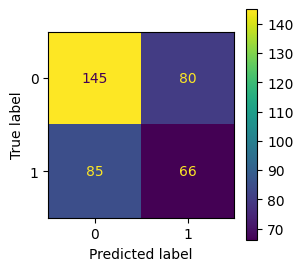

----------------------------------------------------------------------------------------------------------



In [44]:
# Baseline classification (based on probability)
y_prob_1 = round(y_class.value_counts()[1] / (len(y_class)),4)
print('Probability of SOC change is greater than 50 =',y_prob_1)

y_class_pred_train = []
for index, row in X_class_train.iterrows():
    random_number = np.random.rand()
    if (random_number < y_prob_1):
        y_class_pred_train.append(1)
    else:
        y_class_pred_train.append(0)
        
y_class_pred_test = []
for index, row in X_class_test.iterrows():
    random_number = np.random.rand()
    if (random_number < y_prob_1):
        y_class_pred_test.append(1)
    else:
        y_class_pred_test.append(0)

baseline_class_train_accuracy = round(accuracy_score(y_class_train, y_class_pred_train),4)
baseline_class_test_accuracy = round(accuracy_score(y_class_test, y_class_pred_test),4)

# display classification results
display_classification_results(y_class_train, y_class_test, y_class_pred_train, y_class_pred_test)

In [45]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

In [46]:
# models_results [Model,Train Time,Train Accuracy,Test Accuracy]
# add the baseline results
models_results = []
# Baseline results
models_results.append(['Baseline', '', baseline_class_train_accuracy, baseline_class_test_accuracy])

----------------------------------------------------------------------------------------------------------

Classification Report:
                     0           1  accuracy   macro avg  weighted avg
precision    0.781893    0.736842  0.765957    0.759368      0.763801
recall       0.844444    0.649007  0.765957    0.746726      0.765957
f1-score     0.811966    0.690141  0.765957    0.751053      0.763041
support    225.000000  151.000000  0.765957  376.000000    376.000000 

Accuracy Score: 0.766 

Confusion Matrix:
 [[190  35]
 [ 53  98]]


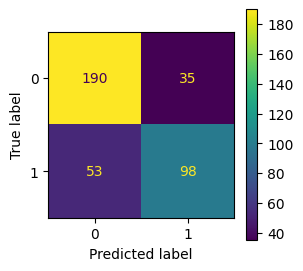

----------------------------------------------------------------------------------------------------------



In [47]:
# (a) Logistic Regression
log_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

time_start = time.time()
log_reg_pipe.fit(X_class_train, y_class_train)
time_end = time.time()
time_taken_log_reg = round((time_end-time_start),4)

y_class_pred_train = log_reg_pipe.predict(X_class_train)
y_class_pred_test = log_reg_pipe.predict(X_class_test)

log_reg_train_accuracy = round(log_reg_pipe.score(X_class_train, y_class_train),4)
log_reg_test_accuracy = round(log_reg_pipe.score(X_class_test, y_class_test),4)

# display classification results
display_classification_results(y_class_train, y_class_test, y_class_pred_train, y_class_pred_test)

# add Logistic Regression results to model_results
models_results.append(['Logistic Regression', time_taken_log_reg, log_reg_train_accuracy, log_reg_test_accuracy])

----------------------------------------------------------------------------------------------------------

Classification Report:
                     0           1  accuracy   macro avg  weighted avg
precision    0.798077    0.648810  0.731383    0.723443      0.738132
recall       0.737778    0.721854  0.731383    0.729816      0.731383
f1-score     0.766744    0.683386  0.731383    0.725065      0.733267
support    225.000000  151.000000  0.731383  376.000000    376.000000 

Accuracy Score: 0.7314 

Confusion Matrix:
 [[166  59]
 [ 42 109]]


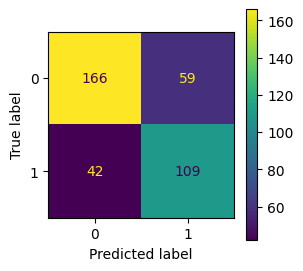

----------------------------------------------------------------------------------------------------------



In [48]:
# (b) KNearestNeighbors
knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

time_start = time.time()
knn_pipe.fit(X_class_train, y_class_train)
time_end = time.time()
time_taken_knn = round((time_end-time_start),4)

y_class_pred_train = knn_pipe.predict(X_class_train)
y_class_pred_test = knn_pipe.predict(X_class_test)

knn_train_accuracy = round(knn_pipe.score(X_class_train, y_class_train),4)
knn_test_accuracy = round(knn_pipe.score(X_class_test, y_class_test),4)

# display classification results
display_classification_results(y_class_train, y_class_test, y_class_pred_train, y_class_pred_test)

# add KNN results to model
models_results.append(['KNN', time_taken_knn, knn_train_accuracy, knn_test_accuracy])

----------------------------------------------------------------------------------------------------------

Classification Report:
                     0           1  accuracy   macro avg  weighted avg
precision    0.823529    0.722581  0.781915    0.773055      0.782989
recall       0.808889    0.741722  0.781915    0.775305      0.781915
f1-score     0.816143    0.732026  0.781915    0.774085      0.782362
support    225.000000  151.000000  0.781915  376.000000    376.000000 

Accuracy Score: 0.7819 

Confusion Matrix:
 [[182  43]
 [ 39 112]]


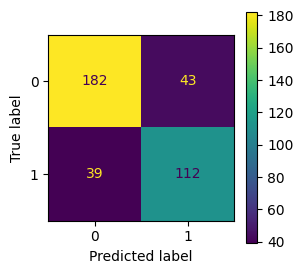

----------------------------------------------------------------------------------------------------------



In [49]:
# (c) Decision Tree
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42,max_depth=6))
])

time_start = time.time()
tree_pipe.fit(X_class_train, y_class_train)
time_end = time.time()
time_taken_tree = round((time_end-time_start),4)

y_class_pred_train = tree_pipe.predict(X_class_train)
y_class_pred_test = tree_pipe.predict(X_class_test)

tree_train_accuracy = round(tree_pipe.score(X_class_train, y_class_train),4)
tree_test_accuracy = round(tree_pipe.score(X_class_test, y_class_test),4)

# display classification results
display_classification_results(y_class_train, y_class_test, y_class_pred_train, y_class_pred_test)
#plot_tree(tree,feature_names=np.array(X_class.columns).tolist(), filled=True)

# add DecisionTree results to model
models_results.append(['DecisonTree', time_taken_tree, tree_train_accuracy, tree_test_accuracy])

----------------------------------------------------------------------------------------------------------

Classification Report:
                     0           1  accuracy   macro avg  weighted avg
precision    0.846154    0.708333  0.784574    0.777244      0.790806
recall       0.782222    0.788079  0.784574    0.785151      0.784574
f1-score     0.812933    0.746082  0.784574    0.779507      0.786086
support    225.000000  151.000000  0.784574  376.000000    376.000000 

Accuracy Score: 0.7846 

Confusion Matrix:
 [[176  49]
 [ 32 119]]


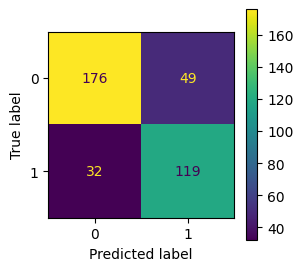

----------------------------------------------------------------------------------------------------------



In [50]:
# (d) Support Vector Machines
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC(kernel='rbf',probability=True))
])

time_start = time.time()
svm_pipe.fit(X_class_train, y_class_train)
time_end = time.time()
time_taken_svm = round((time_end-time_start),4)

y_class_pred_train = svm_pipe.predict(X_class_train)
y_class_pred_test = svm_pipe.predict(X_class_test)

svm_train_accuracy = round(svm_pipe.score(X_class_train, y_class_train),4)
svm_test_accuracy = round(svm_pipe.score(X_class_test, y_class_test),4)

# display classification results
display_classification_results(y_class_train, y_class_test, y_class_pred_train, y_class_pred_test)

# add SVM results to model
models_results.append(['SVM', time_taken_svm, svm_train_accuracy, svm_test_accuracy])

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=poly, svm__probability=True; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=poly, svm__probability=True; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=poly, svm__probability=True; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=rbf, svm__probability=True; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=rbf, svm__probability=True; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=rbf, svm__probability=True; total time=   0.1s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=sigmoid, svm__probability=True; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=3, svm__gamma=0.01, svm__kernel=sigmoid, svm__probability=True; total time=   0.1s
[CV] END svm__C=0.1, svm__degre

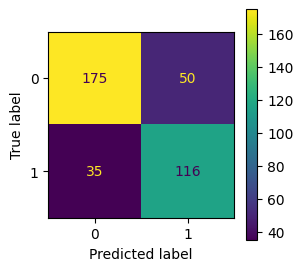

----------------------------------------------------------------------------------------------------------



In [51]:
# SVM is best model based on Accuracy score, hence GridSearch for best parameters for SVM
grid_params = {
    'svm__C': [0.1,1],
    'svm__kernel' : ["poly","rbf","sigmoid"],
    'svm__degree' : [3,5],
    'svm__gamma' : [0.01,0.1,1,'scale'],
    'svm__probability': [True]
}

svm_cv_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC())
])

svm_cv = GridSearchCV(svm_cv_pipe, grid_params, cv = 3, verbose=2)
time_start = time.time()
svm_cv.fit(X_class_train, y_class_train)
time_end = time.time()
time_taken_svm_gridsearch = round((time_end-time_start),4)

svm_best_model = svm_cv.best_estimator_
print('SVM GridSearchCV - Best Parameters =',svm_cv.best_params_)

y_class_pred_train = svm_best_model.predict(X_class_train)
y_class_pred_test = svm_best_model.predict(X_class_test)

svm_train_accuracy = round(svm_best_model.score(X_class_train, y_class_train),4)
svm_test_accuracy = round(svm_best_model.score(X_class_test, y_class_test),4)

# display classification results
display_classification_results(y_class_train, y_class_test, y_class_pred_train, y_class_pred_test)

# add SVM results to model
models_results.append(['SVM GridSearchCV_BestModel', time_taken_svm_gridsearch, svm_train_accuracy, svm_test_accuracy])


In [52]:
# Models Results in a DataFrame
models_results_df = pd.DataFrame(models_results, columns=['Model', 'Train Time (sec)', 'Train Accuracy', 'Test Accuracy'])
models_results_df.set_index('Model', inplace=True)
print('Consolidated Results for the baseline and the classification models:')
models_results_df

Consolidated Results for the baseline and the classification models:


,Train Time (sec),Train Accuracy,Test Accuracy
Model,,,
Baseline,,0.5126,0.5612
Logistic Regression,0.0085,0.7730,0.7660
KNN,0.0088,0.8928,0.7314
DecisonTree,0.0091,0.8282,0.7819
SVM,0.2601,0.8083,0.7846
SVM GridSearchCV_BestModel,48.4943,0.8249,0.7739


The best SVM gridsearch model has a higher train accuracy but a lower test accuracy compared to the regular SVM model.

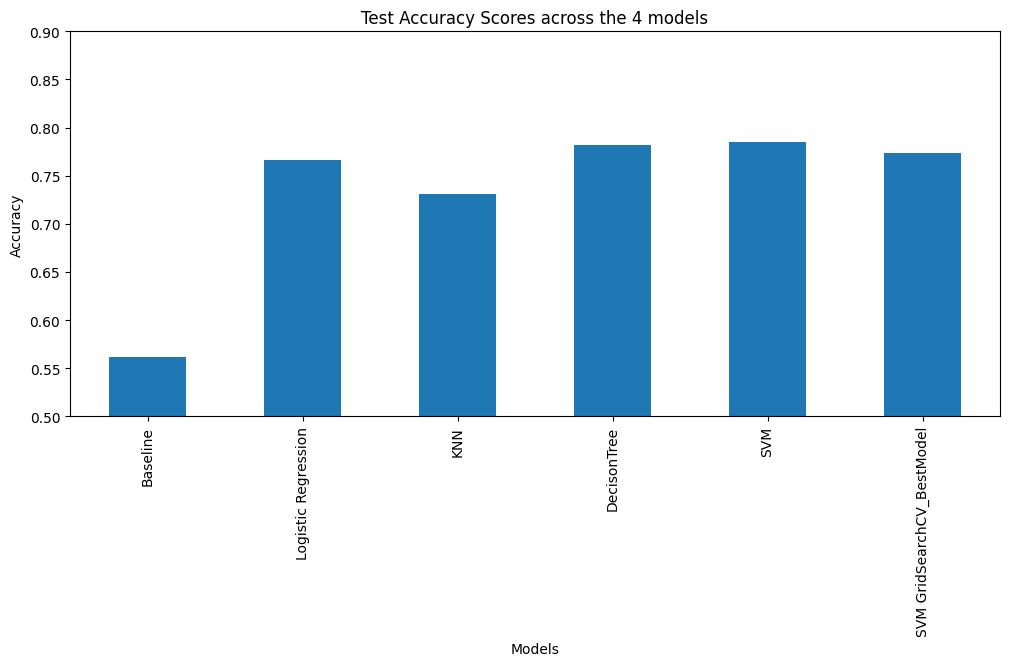

In [53]:
plt.figure(figsize=(12,5))
models_results_df['Test Accuracy'].plot(kind='bar')
plt.title('Test Accuracy Scores across the 4 models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.5, 0.9)
plt.show()

Of the 4 models, SVM has the best accuracy score of 0.7846

Best AUC Score (Logistic Regression model) = 0.8544


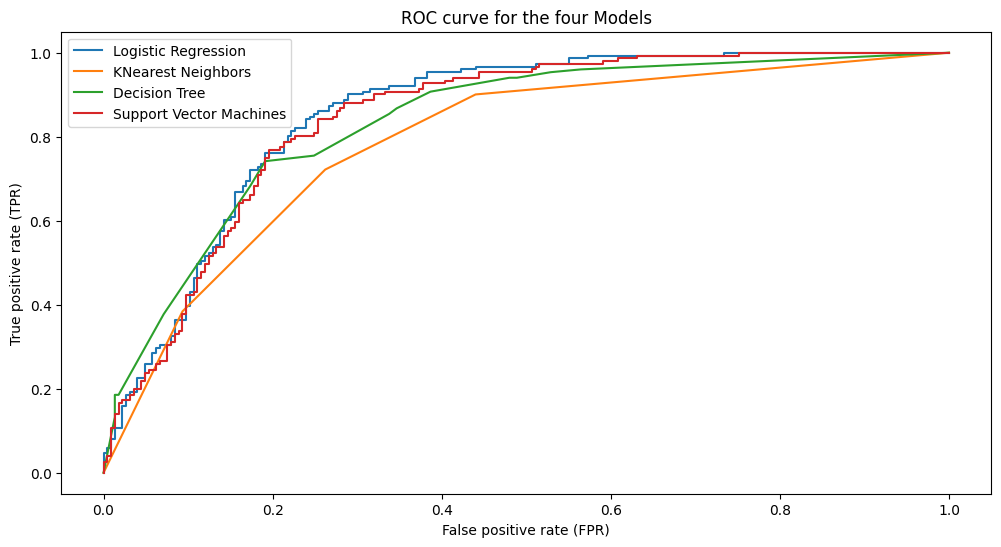

In [54]:
# ROC Curve for the models and computing AUC Score
y_predict_probs_log_reg = log_reg_pipe.predict_proba(X_class_test)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_class_test, y_predict_probs_log_reg[:,1])

y_predict_probs_knn = knn_pipe.predict_proba(X_class_test)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_class_test, y_predict_probs_knn[:,1])

y_predict_probs_tree = tree_pipe.predict_proba(X_class_test)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_class_test, y_predict_probs_tree[:,1])

y_predict_probs_svm = svm_pipe.predict_proba(X_class_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_class_test, y_predict_probs_svm[:,1])


plt.figure(figsize=(12,6))
plt.plot(fpr_log_reg,tpr_log_reg,label='Logistic Regression')
plt.plot(fpr_knn,tpr_knn,label='KNearest Neighbors')
plt.plot(fpr_tree,tpr_tree,label='Decision Tree')
plt.plot(fpr_svm,tpr_svm,label='Support Vector Machines')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.legend()
plt.title('ROC curve for the four Models')
print('Best AUC Score (Logistic Regression model) =',round(auc(fpr_log_reg,tpr_log_reg),4))

The ROC Curve and AUC score of 0.8544 indicate that Logistic Regression provides a good discrimination (high classification accuracy) between the classes.

## Results

The regression analysis indicates that the Energy Wh has a positive relationship with the Energy Capacity, Max Power Requested and the change in the State of Charge. The coefficients on the variables CCS1 and CCS2 (type of plug for charging) are also positive. The Energy Wh for charging can thus be estimated from these variables prior to charging (assuming a good estimate of the Change in State of Charge required for the Battery can be determined), and thus it can be used to calculate the cost of the EV Charging session. The SVM model can be used (along with the other charging attributes) to classify the charging sessions where the Change in the State of Charge is more than 50 percent.